In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
tqdm.pandas()
import os
import gc
import random
from glob import glob
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import warnings
import seaborn as sns
import pickle
import json
import re
import time
import sys
from requests import get
import multiprocessing
import joblib
!pip uninstall lightgbm -y
!pip install lightgbm==3.3.1

class CFG:
    seed = 46
    target = "point_of_interest"
    n_neighbors = 20
    n_splits = 3

    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]

random.seed(CFG.seed)
os.environ["PYTHONHASHSEED"] = str(CFG.seed)
np.random.seed(CFG.seed)

plt.rcParams["font.size"] = 13
warnings.filterwarnings('ignore')

%cd /content/drive/MyDrive/Kaggle/Foursquare/Notebook

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 2.0 MB 32.6 MB/s 
/content/drive/MyDrive/Kaggle/Foursquare/Notebook


In [3]:
OUTPUT_DIR = '../Output'
if not os.path.exists(os.path.join(OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(OUTPUT_DIR, CFG.expID))

In [4]:
train = pd.read_csv("../Input/train.csv")
test = pd.read_csv("../Input/test.csv")
test[CFG.target] = "TEST"

train.head(1)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e


# POIが同じもの同士間の距離を見る

In [ ]:
!pip install haversine
from haversine import haversine, Unit

In [ ]:
multi_poi = train.groupby(CFG.target).apply(len)[train.groupby(CFG.target).apply(len) > 1].index
multi_poi

Index(['P_00001c309a5e0a', 'P_0000561fe92bed', 'P_0000bccb92573c',
       'P_0000c58a53df6d', 'P_00010455487fcf', 'P_000116a2d0a467',
       'P_000163eeb800d7', 'P_00019fb954100b', 'P_000215c1d1aa0b',
       'P_00027058a58996',
       ...
       'P_fffdcf68f8bb29', 'P_fffe0aa02742ce', 'P_fffe2de2642222',
       'P_fffe489c64e3ee', 'P_fffe8b97b215c6', 'P_fffef398f6f50c',
       'P_ffff001f71e321', 'P_ffff287983c417', 'P_ffffa5ef8f6b07',
       'P_fffff25b7a8282'],
      dtype='object', name='point_of_interest', length=314948)

In [ ]:
distances = []
same_POIs = set()
for poi, poi_df in tqdm(train[train[CFG.target].isin(multi_poi)].groupby(CFG.target)):
    N = len(poi_df)
    poi_df = poi_df.reset_index(drop=True)
    for i in range(N - 1):
        for j in range(i + 1, N):
            distances.append((haversine(poi_df.loc[i, ['latitude', 'longitude']], poi_df.loc[j, ['latitude', 'longitude']]), poi_df.loc[i, 'id'], poi_df.loc[j, 'id']))
            same_POIs.add((poi_df.loc[i, 'id'], poi_df.loc[j, 'id']))
            same_POIs.add((poi_df.loc[j, 'id'], poi_df.loc[i, 'id']))

  0%|          | 0/314948 [00:00<?, ?it/s]

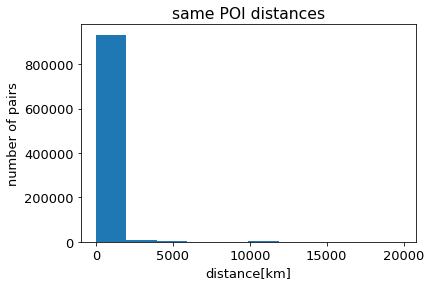

In [ ]:
plt.hist([dist for dist, _, _ in distances])
plt.title("same POI distances")
plt.xlabel("distance[km]")
plt.ylabel("number of pairs")
plt.savefig(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "same_poi_distance.png")))

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

def add_neighbor_features(df):
    dfs = []
    columns = ['id', 'name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']
    for c in columns:
        if c != "id":
            df[c] = df[c].astype(str).str.lower()
    
    knn = KNeighborsRegressor(n_neighbors=min(len(df), CFG.n_neighbors), 
                              metric='haversine', n_jobs=-1)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']], return_distance=True)
    
    targets = df[CFG.target].values
    for i in range(min(len(df), CFG.n_neighbors)):
        df[f"d_near_{i}"] = dists[:, i]
        df[f"near_target_{i}"] = targets[nears[:, i]]
        for c in columns:
            df[f"near_{c}_{i}"] = df[c].values[nears[:, i]]

    for i in range(min(len(df), CFG.n_neighbors), CFG.n_neighbors):
        df[f"d_near_{i}"] = np.nan
        df[f"near_target_{i}"] = np.nan
        for c in columns:
            df[f"near_{c}_{i}"] = np.nan
    return df

train = add_neighbor_features(train)
test = add_neighbor_features(test)

train.head(1)

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_id_19,near_name_19,near_address_19,near_city_19,near_state_19,near_zip_19,near_country_19,near_url_19,near_phone_19,near_categories_19
0,E_000001272c6c5d,café stad oudenaarde,50.859975,3.634196,abdijstraat,nederename,oost-vlaanderen,9700,be,nan,...,E_0905a268bd70fa,frituur 'de groten honger',n46,oudenaarde,nan,nan,be,nan,nan,friteries


In [ ]:
from copy import copy

In [ ]:
near_ids = []
S = set()
for i in range(CFG.n_neighbors):
    S |= set(train[['id', f'near_id_{i}']].apply(lambda x: (x['id'], x[f'near_id_{i}']), axis = 1))
    S |= set(train[['id', f'near_id_{i}']].apply(lambda x: (x[f'near_id_{i}'], x['id']), axis = 1))
    near_ids.append(copy(S))
    contain_percentage = len(same_POIs & S) / len(same_POIs)
    print(f'near_id_{i}: {contain_percentage}')

near_id_0: 0.006406081832461339
near_id_1: 0.18462329945302644
near_id_2: 0.2296889120812875
near_id_3: 0.2574805129494594
near_id_4: 0.27725425380035623
near_id_5: 0.29316056866732665
near_id_6: 0.3061431684066226
near_id_7: 0.3175550208678984
near_id_8: 0.32773173782723464
near_id_9: 0.33663965289957004
near_id_10: 0.34472589776150103
near_id_11: 0.35231766759284294
near_id_12: 0.35911512115164285
near_id_13: 0.3656106293194235
near_id_14: 0.37160640208394924
near_id_15: 0.37726866722146063
near_id_16: 0.3824133116886533
near_id_17: 0.38736753066534246
near_id_18: 0.3918388474313074
near_id_19: 0.3962102171166214


In [ ]:
# # jsonとして保存
# with open(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, 'near_id.json')),'w') as f:
#     s = json.dumps(list(map(list, near_ids)),indent=4)
#     f.write(s)

# jsonから読込
# with open(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, 'near_id.json'))) as f:
#     s = f.read()
#     near_ids = json.loads(s)

In [ ]:
del train, test
gc.collect()

152

In [ ]:
train = pd.read_csv("../Input/train.csv")
test = pd.read_csv("../Input/test.csv")
test[CFG.target] = "TEST"

train.head(1)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

def add_neighbor_features(df):
    dfs = []
    columns = ['id', 'name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']
    for c in columns:
        if c != "id":
            df[c] = df[c].astype(str).str.lower()

    for country, country_df in tqdm(df.groupby("country")):
        country_df = country_df.reset_index(drop=True)
        
        knn = KNeighborsRegressor(n_neighbors=min(len(country_df), CFG.n_neighbors), 
                                  metric='haversine', n_jobs=-1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=True)
        
        targets = country_df[CFG.target].values
        for i in range(min(len(country_df), CFG.n_neighbors)):
            country_df[f"d_near_{i}"] = dists[:, i]
            country_df[f"near_target_{i}"] = targets[nears[:, i]]
            for c in columns:
                country_df[f"near_{c}_{i}"] = country_df[c].values[nears[:, i]]

        for i in range(min(len(country_df), CFG.n_neighbors), CFG.n_neighbors):
            country_df[f"d_near_{i}"] = np.nan
            country_df[f"near_target_{i}"] = np.nan
            for c in columns:
                country_df[f"near_{c}_{i}"] = np.nan

        dfs.append(country_df)
    df = pd.concat(dfs).reset_index(drop=True)
    return df

train = add_neighbor_features(train)
test = add_neighbor_features(test)

train.head(1)

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_id_19,near_name_19,near_address_19,near_city_19,near_state_19,near_zip_19,near_country_19,near_url_19,near_phone_19,near_categories_19
0,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,E_1514d74b987ae1,ahotels piolets park & spa,"carretera de soldeu, s/n",soldeu,andorra,ad100,ad,http://www.ahotels.com/,871787,"hotels, resorts, buffets"


In [ ]:
country_near_ids = []
S = set()
for i in range(CFG.n_neighbors):
    S |= set(train[['id', f'near_id_{i}']].apply(lambda x: (x['id'], x[f'near_id_{i}']), axis = 1))
    S |= set(train[['id', f'near_id_{i}']].apply(lambda x: (x[f'near_id_{i}'], x['id']), axis = 1))
    country_near_ids.append(copy(S))
    contain_percentage = len(same_POIs & S) / len(same_POIs)
    print(f'near_id_{i}: {contain_percentage}')

near_id_0: 0.0064029256088618345
near_id_1: 0.20035181372389146
near_id_2: 0.24740058684717461
near_id_3: 0.2767061229685756
near_id_4: 0.29748985537131395
near_id_5: 0.3141620804984308
near_id_6: 0.3276433635664485
near_id_7: 0.33943291078513166
near_id_8: 0.34991998973175253
near_id_9: 0.3591109128535102
near_id_10: 0.3675685400256496
near_id_11: 0.37523079885071375
near_id_12: 0.38232493742786716
near_id_13: 0.3890161314588171
near_id_14: 0.39516235088158586
near_id_15: 0.40088458426748785
near_id_16: 0.40625226853571217
near_id_17: 0.4114558291767622
near_id_18: 0.4161280921785623


In [ ]:
del train, test
gc.collect()

420

In [ ]:
train = pd.read_csv("../Input/train.csv")
test = pd.read_csv("../Input/test.csv")
test[CFG.target] = "TEST"

train.head(1)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e


In [ ]:
if "google.colab" in sys.modules:
    !pip install Levenshtein

     |████████████████████████████████| 258 kB 18.3 MB/s 
     |████████████████████████████████| 1.8 MB 35.0 MB/s 
     |████████████████████████████████| 103 kB 71.0 MB/s 


In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
import Levenshtein
import difflib

In [ ]:
import time

In [ ]:
train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,café stad oudenaarde,50.859975,3.634196,abdijstraat,nederename,oost-vlaanderen,9700,be,nan,nan,bars,P_677e840bb6fc7e
1,E_000002eae2a589,carioca manero,-22.907225,-43.178244,nan,nan,nan,nan,br,nan,nan,brazilian restaurants,P_d82910d8382a83
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,nan,nan,nan,nan,th,nan,nan,salons / barbershops,P_b1066599e78477
3,E_000008a8ba4f48,turkcell,37.844510,27.844202,adnan menderes bulvarı,nan,nan,nan,tr,nan,nan,mobile phone shops,P_b2ed86905a4cd3
4,E_00001d92066153,restaurante casa cofiño,43.338196,-4.326821,nan,caviedes,cantabria,nan,es,nan,nan,spanish restaurants,P_809a884d4407fb


In [ ]:
train.groupby('categories')[CFG.target].apply(lambda x: (len(set(x)) / len(x), len(set(x)), len(x))).sort_values()

categories
national parks, rivers                                                                 (0.25, 1, 4)
mattress stores                                                      (0.2953795379537954, 179, 606)
residential buildings (apartments / condos), airports                    (0.3333333333333333, 1, 3)
food stands, javanese restaurants                                        (0.3333333333333333, 1, 3)
music schools, middle schools                                            (0.3333333333333333, 1, 3)
                                                                                  ...              
supermarkets, grocery stores, markets                                               (1.0, 171, 171)
pubs, bars                                                                          (1.0, 176, 176)
shopping malls, department stores                                                   (1.0, 193, 193)
college academic buildings, college classrooms                                      (1.0,

In [ ]:
train.groupby('phone')[CFG.target].apply(lambda x: (len(set(x)) / len(x), len(set(x)), len(x))).sort_values()

phone
+18004164441     (0.022222222222222223, 1, 45)
+18028474600                      (0.1, 1, 10)
+17322750999                     (0.125, 1, 8)
+81753237334       (0.16666666666666666, 1, 6)
+18028474563       (0.16666666666666666, 1, 6)
                             ...              
+18004253800                     (1.0, 94, 94)
137678                         (1.0, 102, 102)
8889687282                     (1.0, 106, 106)
88005555505                    (1.0, 127, 127)
+443457484950                  (1.0, 148, 148)
Name: point_of_interest, Length: 293455, dtype: object

In [ ]:
train.groupby('url')[CFG.target].apply(lambda x: (len(set(x)) / len(x), len(set(x)), len(x))).sort_values()

url
http://www.wifi.lv               (0.020833333333333332, 2, 96)
http://www.atverwifi.lv           (0.08333333333333333, 1, 12)
http://umrei.com                                  (0.1, 1, 10)
https://henderson.ru                            (0.125, 3, 24)
https://fmarconi.ru                (0.14285714285714285, 1, 7)
                                             ...              
http://pyaterochka.copiny.com                  (1.0, 155, 155)
http://lawson.jp/twitter/                      (1.0, 159, 159)
http://www.target.com                          (1.0, 186, 186)
http://www.starbucks.com/                      (1.0, 444, 444)
http://www.payless.com/                        (1.0, 687, 687)
Name: point_of_interest, Length: 171149, dtype: object

In [ ]:
train.groupby('zip')[CFG.target].apply(lambda x: (len(set(x)) / len(x), len(set(x)), len(x))).sort_values()

zip
226-0005                   (0.05, 1, 20)
b a12        (0.14285714285714285, 1, 7)
567-0848     (0.14285714285714285, 1, 7)
488-0081     (0.14285714285714285, 1, 7)
935-8531     (0.16666666666666666, 1, 6)
                        ...             
03342-900                  (1.0, 38, 38)
11440                      (1.0, 39, 39)
66053-000                  (1.0, 39, 39)
22451-900                  (1.0, 41, 41)
04551-000                  (1.0, 45, 45)
Name: point_of_interest, Length: 93219, dtype: object

In [ ]:
start = time.time()
for i in tqdm(range(len(train))):
    str1 = train.loc[i, 'name']
    for j in range(i + 1, 100):
        str2 = train.loc[j, 'name']
        gesh = difflib.SequenceMatcher(None, str1, str2).ratio()
print(time.time())

  0%|          | 0/1138812 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
def str_match_distance(idx1, idx2, df):
    print(idx1, idx2)
    print(1 - difflib.SequenceMatcher(None, df.loc[idx1, 'name'], df.loc[idx2, 'name']).ratio())
    return 1 - difflib.SequenceMatcher(None, df.loc[idx1, 'name'], df.loc[idx2, 'name']).ratio()

In [ ]:
name_ids = []
S = set()
for i in range(CFG.n_neighbors):
    S |= set(train[['id', f'near_id_{i}']].apply(lambda x: (x['id'], x[f'near_id_{i}']), axis = 1))
    S |= set(train[['id', f'near_id_{i}']].apply(lambda x: (x[f'near_id_{i}'], x['id']), axis = 1))
    name_ids.append(copy(S))
    contain_percentage = len(same_POIs & S) / len(same_POIs)
    print(f'near_id_{i}: {contain_percentage}')

In [ ]:
del train, test
gc.collect()

In [ ]:
for i in range(CFG.n_neighbors):
    for j in range(CFG.n_neighbors):
        contain_percentage = len((near_ids[i] & name_ids[j]) & same_POIs) / len(same_POIs)
        print(f"near_ids:{i}, name_ids{j}: {contain_percentage}")

In [ ]:
for i in range(CFG.n_neighbors):
    for j in range(CFG.n_neighbors):
        contain_percentage = len((country_near_ids[i] & name_ids[j]) & same_POIs) / len(same_POIs)
        print(f"country_near_ids:{i}, name_ids{j}: {contain_percentage}")

In [ ]:
train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,café stad oudenaarde,50.859975,3.634196,abdijstraat,nederename,oost-vlaanderen,9700,be,nan,nan,bars,P_677e840bb6fc7e
1,E_000002eae2a589,carioca manero,-22.907225,-43.178244,nan,nan,nan,nan,br,nan,nan,brazilian restaurants,P_d82910d8382a83
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,nan,nan,nan,nan,th,nan,nan,salons / barbershops,P_b1066599e78477
3,E_000008a8ba4f48,turkcell,37.844510,27.844202,adnan menderes bulvarı,nan,nan,nan,tr,nan,nan,mobile phone shops,P_b2ed86905a4cd3
4,E_00001d92066153,restaurante casa cofiño,43.338196,-4.326821,nan,caviedes,cantabria,nan,es,nan,nan,spanish restaurants,P_809a884d4407fb


In [ ]:
for i in range(CFG.n_neighbors):
    for j in range(CFG.n_neighbors):
        contain_percentage = len((near_ids[i] | country_near_ids[j]) & same_POIs) / len(same_POIs)
        print(f"near_ids:{i}, country_near_ids{j}: {contain_percentage}")

near_ids:0, country_near_ids0: 0.006672256689352901
near_ids:0, country_near_ids1: 0.2005001562330682
near_ids:0, country_near_ids2: 0.2475100025986241
near_ids:0, country_near_ids3: 0.2768018617510939
near_ids:0, country_near_ids4: 0.2975708651103679
near_ids:0, country_near_ids5: 0.31423782986481896
near_ids:0, country_near_ids6: 0.3277170087837703
near_ids:0, country_near_ids7: 0.3395044518533871
near_ids:0, country_near_ids8: 0.34998837457640847
near_ids:0, country_near_ids9: 0.3591761414745666
near_ids:0, country_near_ids10: 0.3676306124231065
near_ids:0, country_near_ids11: 0.375257100714043
near_ids:0, country_near_ids12: 0.3823501872166632
near_ids:0, country_near_ids13: 0.38904032917307996
near_ids:0, country_near_ids14: 0.3951844444467824
near_ids:0, country_near_ids15: 0.4009024695345517
near_ids:0, country_near_ids16: 0.4062691017282428
near_ids:0, country_near_ids17: 0.41147266236929286
near_ids:0, country_near_ids18: 0.416144925371093
near_ids:0, country_near_ids19: 0.420

In [ ]:
for i in range(CFG.n_neighbors):
    for j in range(CFG.n_neighbors):
        tmp = (near_ids[i] | country_near_ids[j])
        tmp2 = tmp & same_POIs
        contain_percentage = len(tmp2) / len(same_POIs)
        print(f"near_ids:{i}, country_near_ids{j}: {contain_percentage}, {len(tmp)}, {len(tmp2)}, {len(tmp2) / len(tmp)}")

near_ids:0, country_near_ids0: 0.006672256689352901, 1157352, 12684, 0.01095950065321527
near_ids:0, country_near_ids1: 0.2005001562330682, 2695797, 381152, 0.14138750061670075
near_ids:0, country_near_ids2: 0.2475100025986241, 4197523, 470518, 0.11209420412943538
near_ids:0, country_near_ids3: 0.2768018617510939, 5642405, 526202, 0.09325845982342636
near_ids:0, country_near_ids4: 0.2975708651103679, 7089761, 565684, 0.07978886735392067
near_ids:0, country_near_ids5: 0.31423782986481896, 8523773, 597368, 0.0700825796275898
near_ids:0, country_near_ids6: 0.3277170087837703, 9956956, 622992, 0.06256851993721776
near_ids:0, country_near_ids7: 0.3395044518533871, 11385024, 645400, 0.05668850588281588
near_ids:0, country_near_ids8: 0.34998837457640847, 12813444, 665330, 0.051924369435727036
near_ids:0, country_near_ids9: 0.3591761414745666, 14238946, 682796, 0.04795270661185175
near_ids:0, country_near_ids10: 0.3676306124231065, 15666132, 698868, 0.0446101181836078
near_ids:0, country_near_

In [ ]:
train_distance_features_path = os.path.join(OUTPUT_DIR, os.path.join('Exp026', "train_distance_features.csv"))
test_distance_features_path = os.path.join(OUTPUT_DIR, os.path.join('Exp026', "test_distance_features.csv"))

if os.path.exists(train_distance_features_path) and os.path.exists(test_distance_features_path):
    # train = pd.read_csv(train_distance_features_path)
    test = pd.read_csv(test_distance_features_path)

In [ ]:
cnt = 0
for column in test.columns:
    if '1' in column:
        print(column)
        cnt += 1
print(cnt)

d_near_1
near_target_1
near_id_1
near_name_1
near_address_1
near_city_1
near_state_1
near_zip_1
near_new_country_1
near_url_1
near_phone_1
near_categories_1
near_name_1_gesh
near_name_1_leven
near_name_1_jaro
near_name_1_lcs
near_name_1_len
near_name_1_nleven
near_name_1_nlcsi
near_name_1_nlcs0
near_address_1_gesh
near_address_1_leven
near_address_1_jaro
near_address_1_lcs
near_address_1_len
near_address_1_nleven
near_address_1_nlcsi
near_address_1_nlcs0
near_city_1_gesh
near_city_1_leven
near_city_1_jaro
near_city_1_lcs
near_city_1_len
near_city_1_nleven
near_city_1_nlcsi
near_city_1_nlcs0
near_state_1_gesh
near_state_1_leven
near_state_1_jaro
near_state_1_lcs
near_state_1_len
near_state_1_nleven
near_state_1_nlcsi
near_state_1_nlcs0
near_zip_1_gesh
near_zip_1_leven
near_zip_1_jaro
near_zip_1_lcs
near_new_country_1_gesh
near_new_country_1_leven
near_new_country_1_jaro
near_new_country_1_lcs
near_url_1_gesh
near_url_1_leven
near_url_1_jaro
near_url_1_lcs
near_url_1_len
near_url_1_nleve

In [ ]:
cnt = 0
for column in test.columns:
    flag = True
    for x in '0123456789':
        if x in column:
            flag = False
            break
    if flag:
        print(column)
        cnt += 1
print(cnt)

id
name
latitude
longitude
address
city
state
zip
country
url
phone
categories
point_of_interest
new_country
14


In [ ]:
test.shape

(5, 734)

In [ ]:
72 * 10

720

In [ ]:
CFG.n_neighbors = 10

In [ ]:
for i in range(CFG.n_neighbors):
    a